Założenia projektu:
- obróbka i analiza danych
- zastosowanie klasyfikacji lub regresji
- zastosowanie hiperparametrów w budowie modeli
- wyniki badań w formie wykresów i tabel
- rozwiązanie powinno przynieść przyrost wartości biznesowej
- [opcjonalnie] zbadanie wpływu PCA na wyniki
- [opcjonalnie] uwzględnienie zapotrzebowania na wartości wprowadzane przez użytkownika

https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score


In [3]:
df = pd.read_csv("/Users/katarzyna/Desktop/DataScience/jdszr10-TheChaosMakers/projekt_3_ML/neo_v2.csv")

Analiza danych

In [4]:
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [5]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [6]:
print(df['sentry_object'].unique())
print(df['orbiting_body'].unique())

[False]
['Earth']


Data cleaning

orbiting_body oraz sentry_obcject mają tylko jedną wartość, więc je usuwam.  Tak samo name i id nie będą wchodzić w analizy. 

In [31]:
print(df.isnull().sum())

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
dtype: int64


In [7]:
df.drop(columns = ['name','sentry_object', 'orbiting_body', 'id'], inplace= True)

In [8]:
clean = pd.get_dummies(df, columns = ['hazardous'], drop_first= True)

In [9]:
clean

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous_True
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1
...,...,...,...,...,...,...
90831,0.026580,0.059435,52078.886692,1.230039e+07,25.00,0
90832,0.016771,0.037501,46114.605073,5.432121e+07,26.00,0
90833,0.031956,0.071456,7566.807732,2.840077e+07,24.60,0
90834,0.007321,0.016370,69199.154484,6.869206e+07,27.80,0


In [10]:
columns = list(clean.columns.values)
columns.remove('hazardous_True')
print(columns)
print(len(columns))

['est_diameter_min', 'est_diameter_max', 'relative_velocity', 'miss_distance', 'absolute_magnitude']
5


In [11]:
percentage_distribution = clean['hazardous_True'].value_counts(normalize=True)
percentage_distribution 

0    0.902682
1    0.097318
Name: hazardous_True, dtype: float64

* Przypisywanie wagi do 1, np. 0.1 do 0 0.9 do 1, aby skupić się na wykrywaniu 1
* Preparowanie zbioru danych tak, aby model uczył się na podziale 50/50 1 do 0 
* Upsampling -> generowanie jedynek tak, aby było ich więcej 

* Recall i precyzja jako metryka efektywności


# Korelacje

In [12]:

correlations = []
for col in columns:
    corr_coeff, p_value = sci.pearsonr(clean['hazardous_True'], clean[col])
    correlations.append((col, corr_coeff, p_value))


correlations.sort(key=lambda x: abs(x[1]), reverse=True)


for col, corr_coeff, p_value in correlations:
    significance = "insignificant" if p_value > 0.05 else "significant"
    print(f"{col}:\n  Pearson correlation: {corr_coeff:.4f} ({significance})\n  p-value: {p_value:.4f}\n")

absolute_magnitude:
  Pearson correlation: -0.3653 (significant)
  p-value: 0.0000

relative_velocity:
  Pearson correlation: 0.1912 (significant)
  p-value: 0.0000

est_diameter_max:
  Pearson correlation: 0.1834 (significant)
  p-value: 0.0000

est_diameter_min:
  Pearson correlation: 0.1834 (significant)
  p-value: 0.0000

miss_distance:
  Pearson correlation: 0.0423 (significant)
  p-value: 0.0000



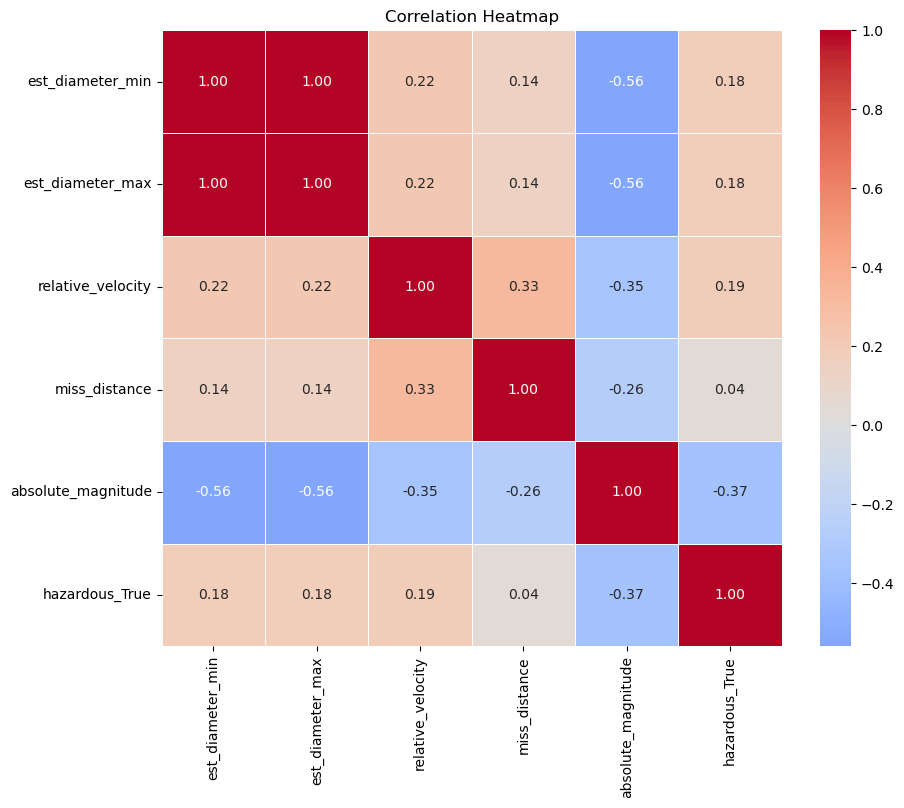

In [13]:
c = clean.corr() 


plt.figure(figsize=(10, 8))
sns.heatmap(c, annot=True, cmap='coolwarm', center=0, fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Wykresy

(0.0, 1.0)

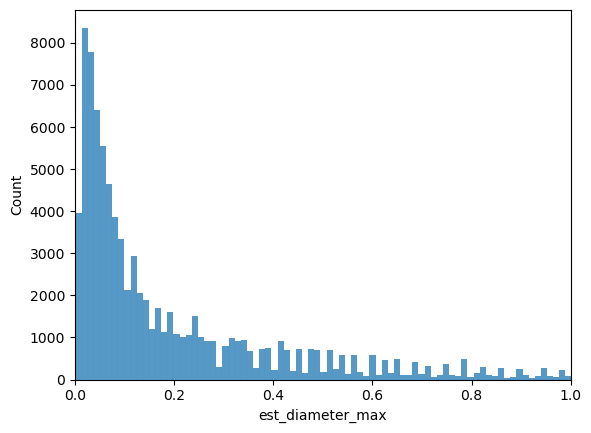

In [26]:
sns.histplot(data=clean, x='est_diameter_max')
lower_limit = 0  
upper_limit = 1  
plt.xlim(lower_limit, upper_limit)

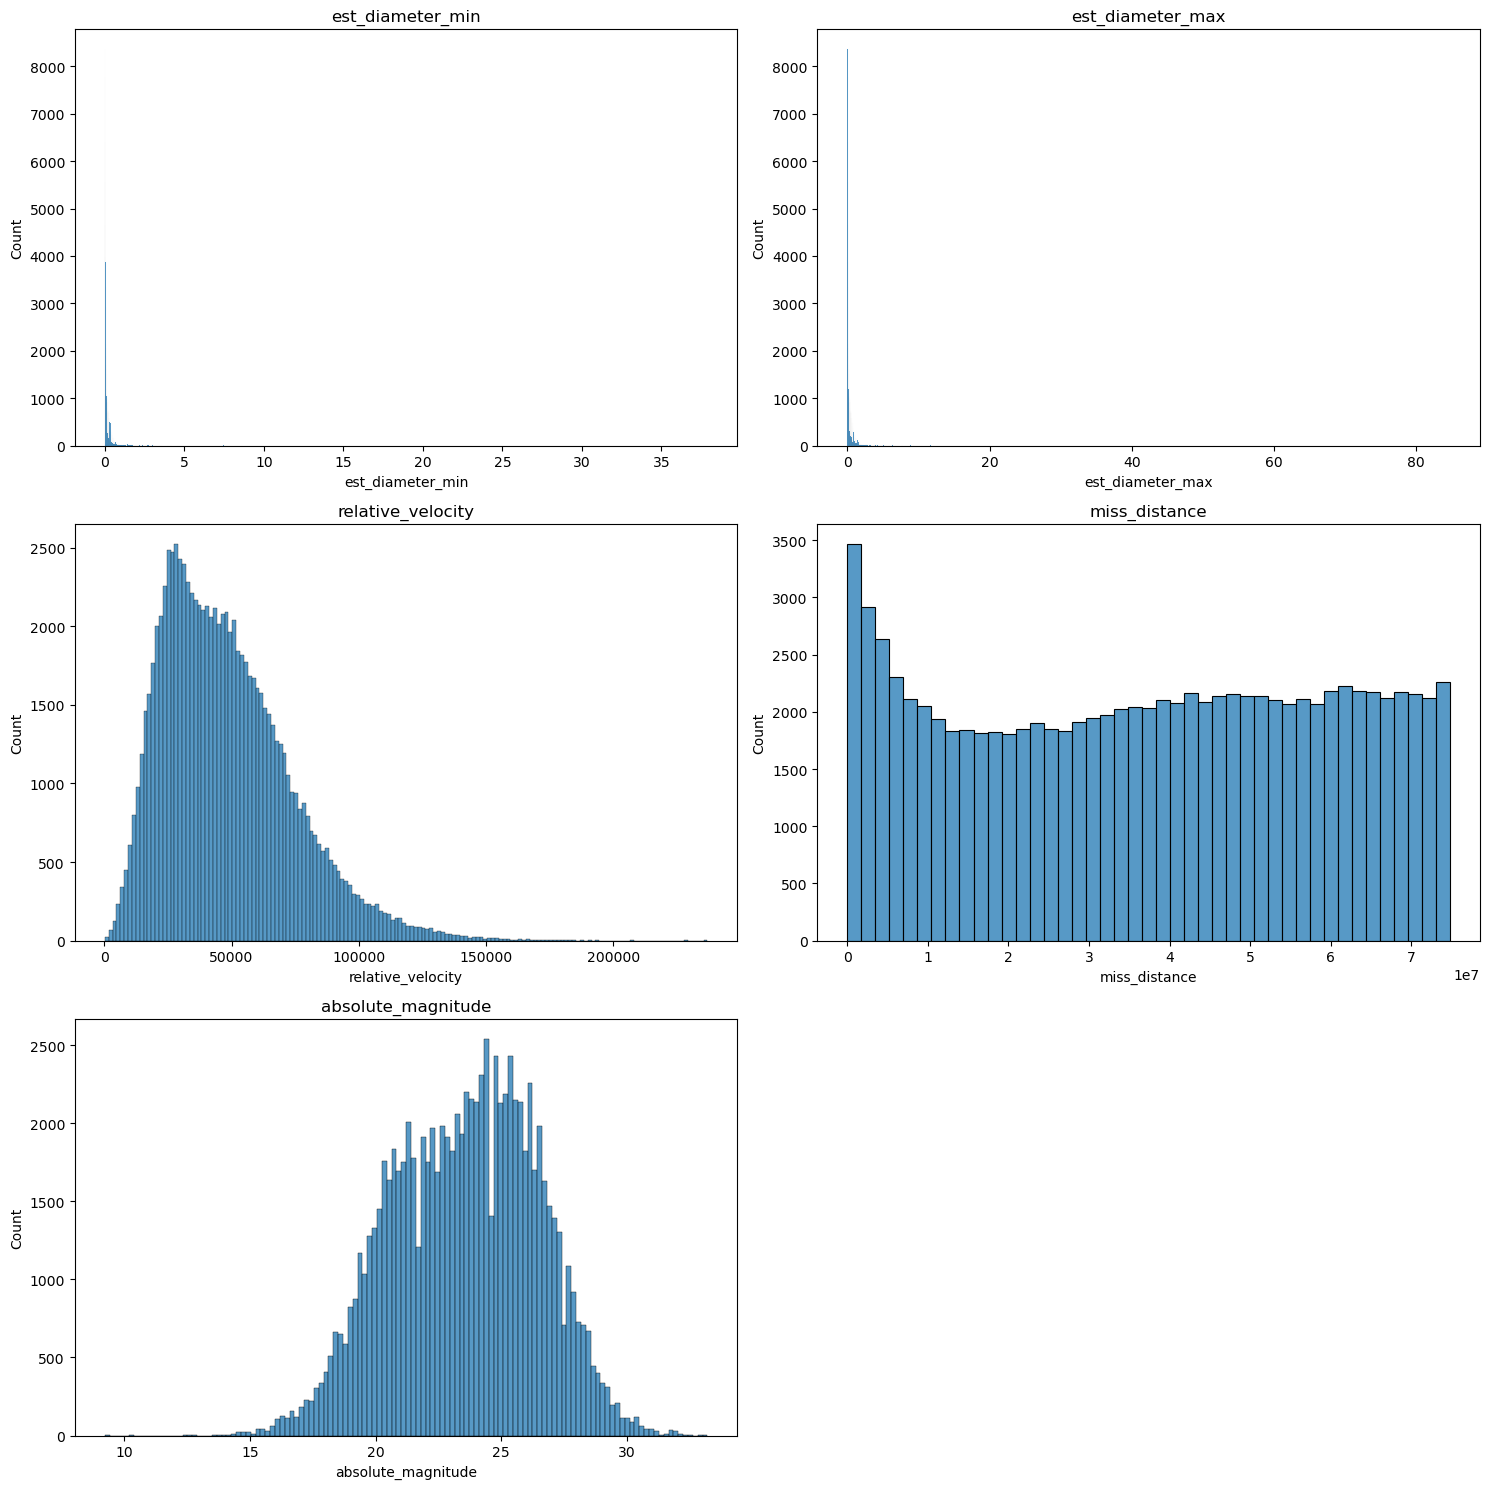

In [14]:
n_cols = 2
n_rows = (len(columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()


for i, col in enumerate(columns):
    sns.histplot(data=clean, x=col, ax=axes[i])
    axes[i].set_title(f'{col}')


for i in range(len(columns), n_rows * n_cols):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()

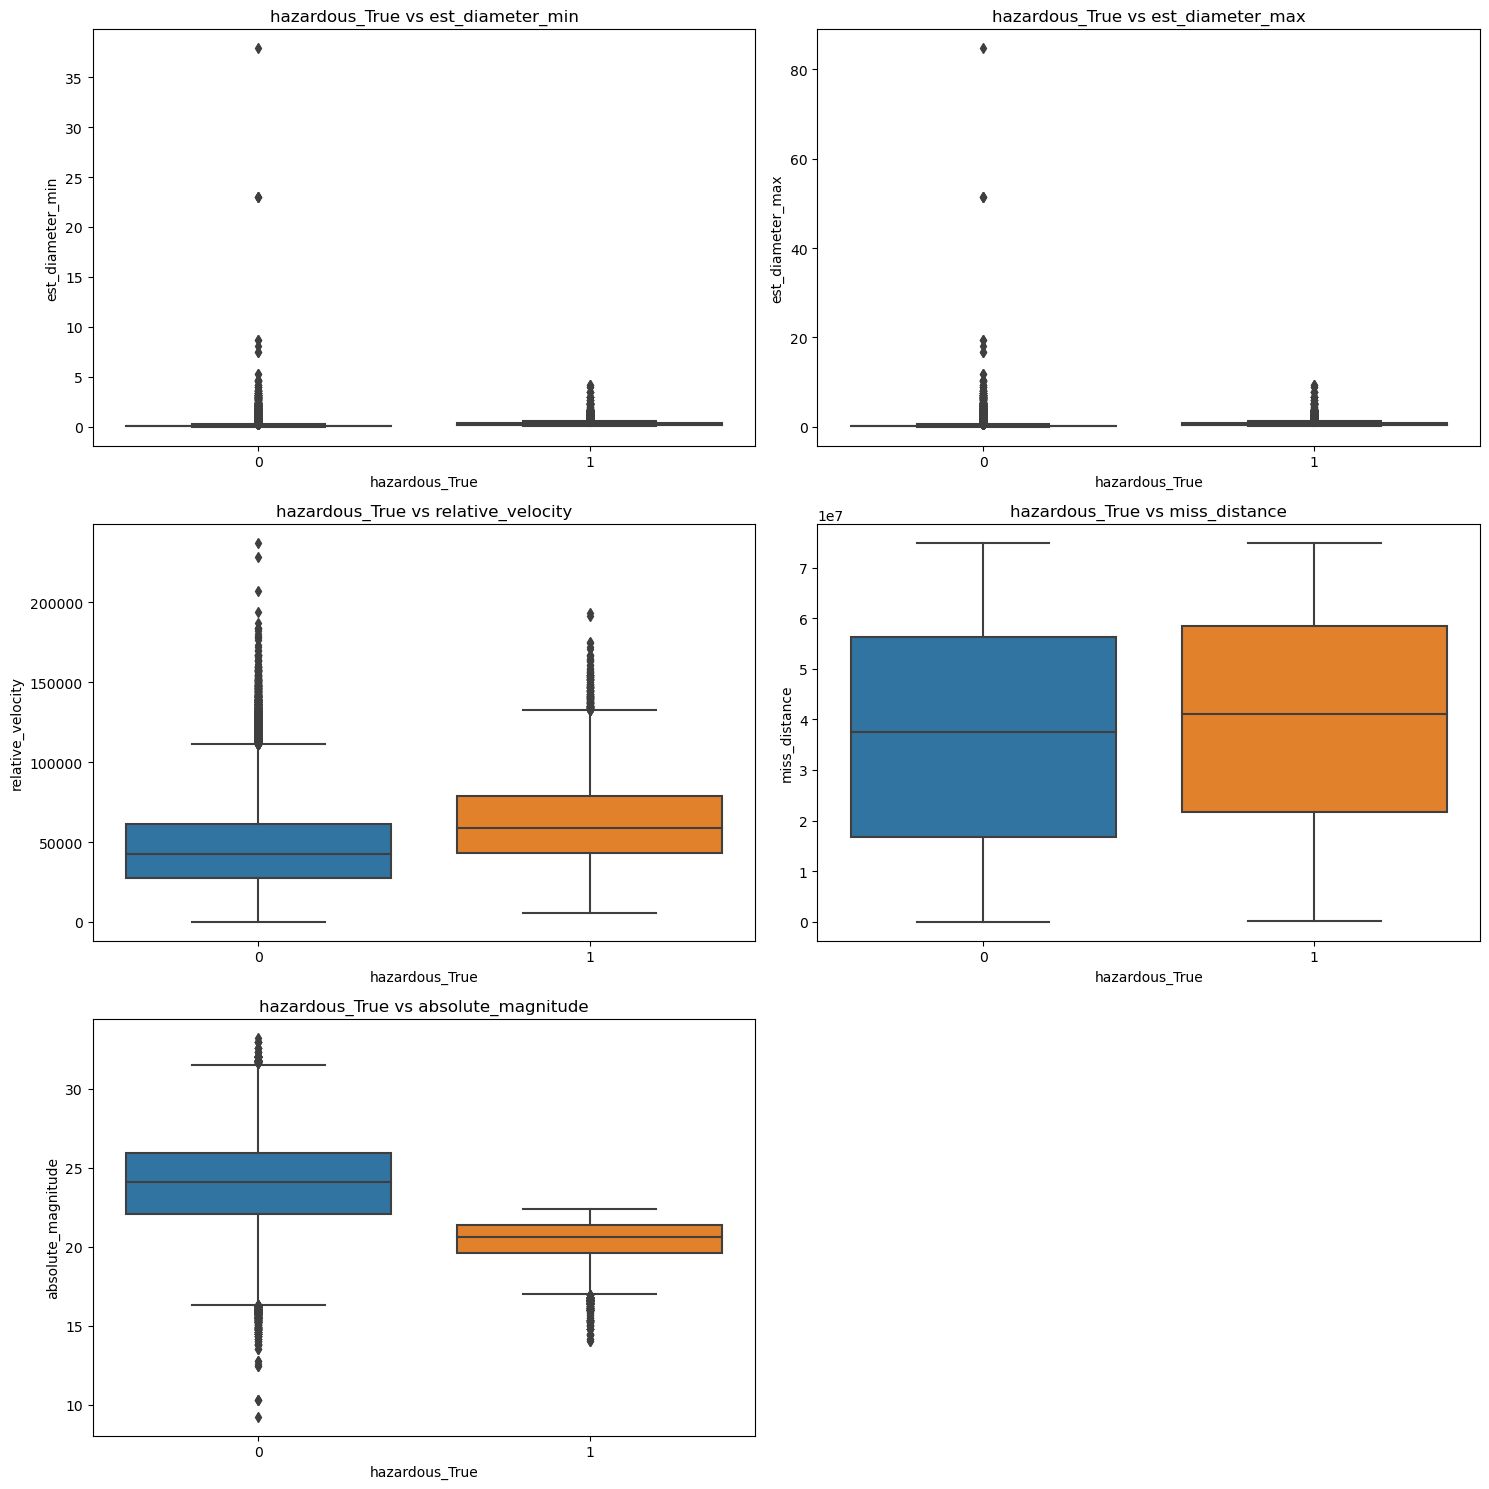

In [15]:
n_cols = 2
n_rows = (len(columns) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.boxplot(data=clean, x='hazardous_True', y=col, ax=axes[i])
    axes[i].set_title(f'hazardous_True vs {col}')


for i in range(len(columns), n_rows * n_cols):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()

Na podstawie analizy korelacji wywalamy est_diameter_min

In [ ]:
clean.drop(columns = ['est_diameter_min'], inplace= True)
columns.remove('est_diameter_min')

In [45]:
len(columns)

4

In [37]:
clean.head()

,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous_True
0,2.679415,13569.249224,5.483974e+07,16.73,0
1,0.594347,73588.726663,6.143813e+07,20.00,1
2,1.614507,114258.692129,4.979872e+07,17.83,0
3,0.215794,24764.303138,2.543497e+07,22.20,0
4,0.570217,42737.733765,4.627557e+07,20.09,1


Lasy losowe

In [42]:
random_state = 42

In [38]:
X_train, X_test, y_train, y_test = train_test_split(clean[columns], clean['hazardous_True'], test_size=0.3, random_state = 42)

Dobór parametrów

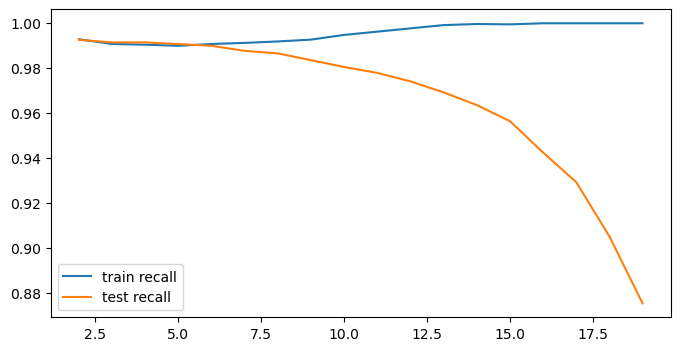

The best max_depth value for RandomForest is 2 with test recall of 0.9924642049736248


In [84]:
from sklearn.metrics import recall_score

max_depths = list(range(2, 20))
train_recall = []
test_recall = []

for param in max_depths:
    model = RandomForestClassifier(max_depth=param, random_state=random_state, class_weight='balanced').fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    train_recall.append(recall_score(y_train, predict_train))
    test_recall.append(recall_score(y_test, predict_test))

highest_test_recall_index = test_recall.index(max(test_recall))
best_max_depth = max_depths[highest_test_recall_index]

plt.figure(figsize=(8, 4))
plt.plot(max_depths, train_recall, label='train recall')
plt.plot(max_depths, test_recall, label='test recall')
plt.legend()
plt.show()

print(f"The best max_depth value for RandomForest is {best_max_depth} with test recall of {test_recall[highest_test_recall_index]}")


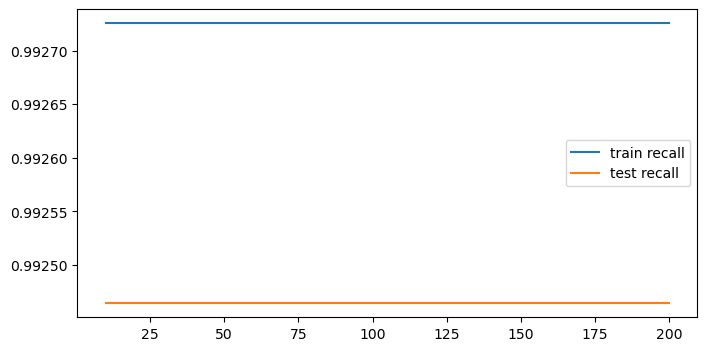

The best n_estimators value for RandomForest is 10 with test recall of 0.9924642049736248


In [85]:


n_estimatorss = list(range(10, 201, 10))
train_recall = []
test_recall = []

for param in n_estimatorss:
    model = RandomForestClassifier(n_estimators=param, random_state=random_state, class_weight='balanced', max_depth=best_max_depth).fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    train_recall.append(recall_score(y_train, predict_train))
    test_recall.append(recall_score(y_test, predict_test))

highest_test_recall_index = test_recall.index(max(test_recall))
best_n_estimators = n_estimatorss[highest_test_recall_index]

plt.figure(figsize=(8, 4))
plt.plot(n_estimatorss, train_recall, label='train recall')
plt.plot(n_estimatorss, test_recall, label='test recall')
plt.legend()
plt.show()

print(f"The best n_estimators value for RandomForest is {best_n_estimators} with test recall of {test_recall[highest_test_recall_index]}")


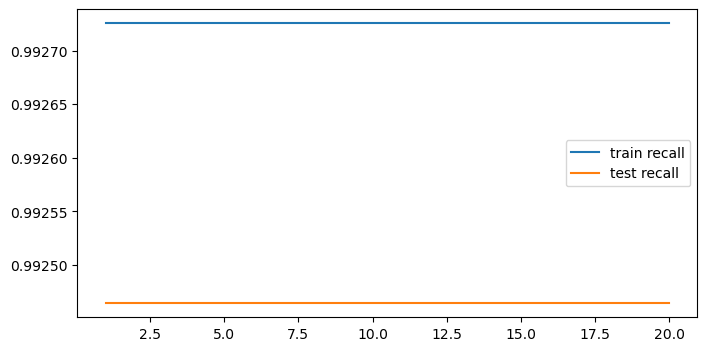

The best min_samples_leaf value for RandomForest is 1 with test recall of 0.9924642049736248


In [86]:


min_samples_leafs = list(range(1, 21))
train_recall = []
test_recall = []

for param in min_samples_leafs:
    model = RandomForestClassifier(min_samples_leaf=param, n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=random_state, class_weight='balanced').fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    train_recall.append(recall_score(y_train, predict_train))
    test_recall.append(recall_score(y_test, predict_test))

highest_test_recall_index = test_recall.index(max(test_recall))
best_min_samples_leaf = min_samples_leafs[highest_test_recall_index]

plt.figure(figsize=(8, 4))
plt.plot(min_samples_leafs, train_recall, label='train recall')
plt.plot(min_samples_leafs, test_recall, label='test recall')
plt.legend()
plt.show()

print(f"The best min_samples_leaf value for RandomForest is {best_min_samples_leaf} with test recall of {test_recall[highest_test_recall_index]}")


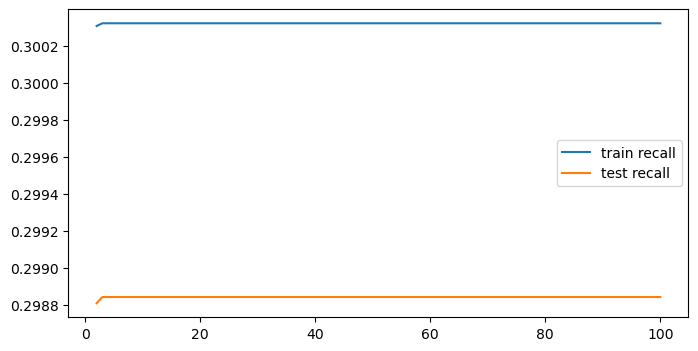

The best max_leaf_nodes value for RandomForest is 3 with test recall of 0.2988427501701838


In [88]:
max_leaf_nodess = list(range(2, 101))  
train_recall = []
test_recall = []

for param in max_leaf_nodess:
    model = RandomForestClassifier(max_leaf_nodes=param, n_estimators=best_n_estimators, min_samples_leaf=best_min_samples_leaf, max_depth=best_max_depth, random_state=random_state, class_weight='balanced').fit(X_train, y_train)
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    train_recall.append(recall_score(predict_train, y_train))
    test_recall.append(recall_score(predict_test, y_test))

highest_test_recall_index = test_recall.index(max(test_recall))
best_max_leaf_nodes = max_leaf_nodess[highest_test_recall_index]

plt.figure(figsize=(8, 4))
plt.plot(max_leaf_nodess, train_recall, label='train recall')
plt.plot(max_leaf_nodess, test_recall, label='test recall')
plt.legend()
plt.show()

print(f"The best max_leaf_nodes value for RandomForest is {best_max_leaf_nodes} with test recall of {test_recall[highest_test_recall_index]}")


In [89]:
rfc = RandomForestClassifier(random_state = random_state, max_leaf_nodes = best_max_leaf_nodes, n_estimators = best_n_estimators, min_samples_leaf = best_min_samples_leaf, max_depth = best_max_depth, class_weight='balanced')
rfc  = rfc.fit(X_train, y_train)
rfc

RandomForestClassifier(class_weight='balanced', max_depth=2, max_leaf_nodes=3,
                       n_estimators=10, random_state=42)

In [90]:
pred_rfc_train = rfc.predict(X_train)
pred_rfc_test = rfc.predict(X_test)

In [91]:
print(classification_report(y_train, pred_rfc_train))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86     57399
           1       0.30      0.99      0.46      6186

    accuracy                           0.77     63585
   macro avg       0.65      0.87      0.66     63585
weighted avg       0.93      0.77      0.82     63585



In [92]:
print(classification_report(y_test, pred_rfc_test)) 

              precision    recall  f1-score   support

           0       1.00      0.75      0.86     24597
           1       0.30      0.99      0.46      2654

    accuracy                           0.77     27251
   macro avg       0.65      0.87      0.66     27251
weighted avg       0.93      0.77      0.82     27251



Macierz pomyłek

In [93]:
cm = confusion_matrix(y_test, pred_rfc_test)


In [94]:
def print_confusion_matrix(confusion_matrix, class_names):
    df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    
    print(df)

class_names = ['Not Hazardous', 'Hazardous']

print('\nConfusion matrix:')
print_confusion_matrix(cm, class_names)


Confusion matrix:
Predicted      Not Hazardous  Hazardous
Actual                                 
Not Hazardous          18417       6180
Hazardous                 20       2634


skalowanie?
Rozkłady normalne